### DBSCAN Example and Implementation 

In this example file we:
1. Set up helper functions 
2. Build a few DBSCAN datasets
3. Run DBSCAN
4. Run **parameter sweeps** and visualize the result as a **grid of plots** 

**DBSCAN parameters swept**
- `eps` (ε): neighborhood radius
- `min_samples`: minimum points to form a dense region
- (`metric`): shown as separate grids for Euclidean vs Manhattan

## NOTE: We run a lot of DBSCAN models in this notebook so this file may take ~10 minutes to run locally. 

## 1) DBSCAN Setup

We’ll use:
- `numpy` for arrays,
- `matplotlib` for plotting,
- `sklearn.datasets` for toy datasets,
- The `rice_ml` `DBScan` implementation (from `src/rice_ml/unsupervised_learning/bdscan.py`).

We will fix our random seed for reproducibility

Our datasets will be from sklearn
- make_moons
- make_circles
- make_blobs



In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler

from rice_ml.unsupervised_learning.dbscan import DBScan

#fix seed for reproducibility 
np.random.seed(7)
plt.rcParams["figure.dpi"] = 130


## 2) Helper functions (plotting + reporting)

We’ll keep these helpers consistent across datasets so the sweep grids are easy to compare.
- `summarize_dbscan will` give us summary statisics about each DBScan model we run
- `plot_dbscan_scatter` will plot DBScan on a fixed set of axis to visualize parameter sweeps
- `sweep_grid` will sweep over a set range of the `eps` and `min_samples` to produce visualizations 



In [2]:
def summarize_dbscan(labels: np.ndarray) -> dict:
    """Return a few quick summary stats."""
    labels = np.asarray(labels)
    noise = int(np.sum(labels == 0))
    k = int(labels.max())  # clusters are 1..k; noise is 0
    return {"clusters": k, "noise_points": noise}


def plot_dbscan_scatter(ax, X: np.ndarray, labels: np.ndarray, title: str) -> None:
    """Scatter plot for DBSCAN output on a given axes."""
    X = np.asarray(X)
    labels = np.asarray(labels)

    ax.scatter(X[:, 0], X[:, 1], c=labels, s=10)
    ax.set_title(title, fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])


def sweep_grid(X: np.ndarray, dataset_name: str, eps_values: list[float], min_samples_values: list[int], metric: str = "euclidean") -> None:
    """Plot a (rows=min_samples) x (cols=eps) grid for DBSCAN parameter sweeps."""
    n_rows = len(min_samples_values)
    n_cols = len(eps_values)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.0 * n_cols, 2.6 * n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = np.array([axes])
    elif n_cols == 1:
        axes = np.array([[ax] for ax in axes])

    for r, m in enumerate(min_samples_values):
        for c, e in enumerate(eps_values):
            model = DBScan(eps=e, min_samples=m, metric=metric)
            labels, k = model.fit_predict(X)
            s = summarize_dbscan(labels)
            title = f"ε={e:.2f}, min={m}\nclusters={k}, noise={s['noise_points']}"
            plot_dbscan_scatter(axes[r, c], X, labels, title)

    fig.suptitle(f"{dataset_name} — DBSCAN sweep (metric={metric})", fontsize=12)
    plt.tight_layout(rect=[0, 0.02, 1, 0.95])
    plt.show()

## 3) Example A — Two Moons

Two moons is a classic DBSCAN test because clusters are **non-spherical** and separated by density. We will first generate a single instance of make_moons and test it with one set of DBScan parameters. Then we will run a paramter sweep to see how changing  `eps` and `min_samples` effects our results.


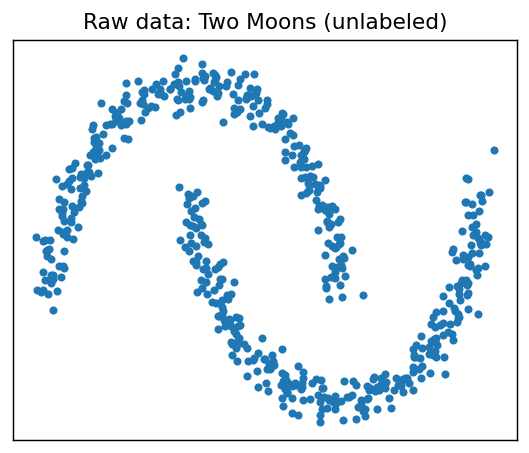

In [3]:
X_moons, _ = make_moons(n_samples=600, noise=0.06, random_state=7)

plt.figure(figsize=(5, 4))
plt.scatter(X_moons[:, 0], X_moons[:, 1], s=12)
plt.title("Raw data: Two Moons (unlabeled)")
plt.xticks([]); plt.yticks([])
plt.show()


We will set up our DBScan model for the two moons with `eps=0.22`, `min_samples=6`, and `metric="euclidean"`

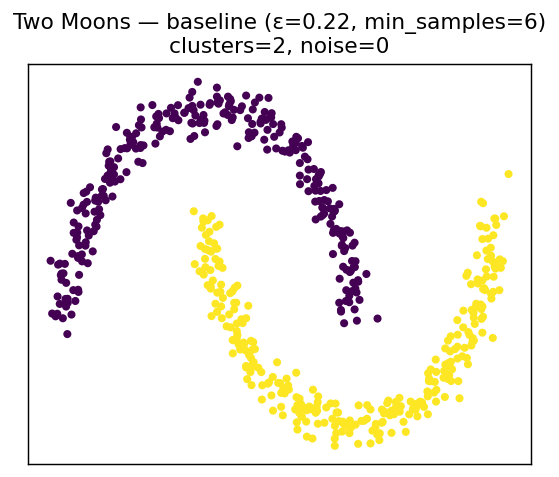

In [4]:
# A reasonable single-run baseline
model = DBScan(eps=0.22, min_samples=6, metric="euclidean")
labels, k = model.fit_predict(X_moons)
s = summarize_dbscan(labels)

plt.figure(figsize=(5, 4))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=labels, s=12)
plt.title(f"Two Moons — baseline (ε=0.22, min_samples=6)\nclusters={k}, noise={s['noise_points']}")
plt.xticks([]); plt.yticks([])
plt.show()


### Parameter sweep 
Now we will perform a parameter sweep to better visualize how our choice of epsilon and min_samples effects our clustering.
For the gir of plots: Rows = `min_samples`, columns = `eps`. Since the make_moons data is very clean, the major change that comes with different parameter sets is the identification of the top-right most point as noise or as part of the lower moon. Additionally, our metric doe alter our recognition of the top-right most point as noise or not. 


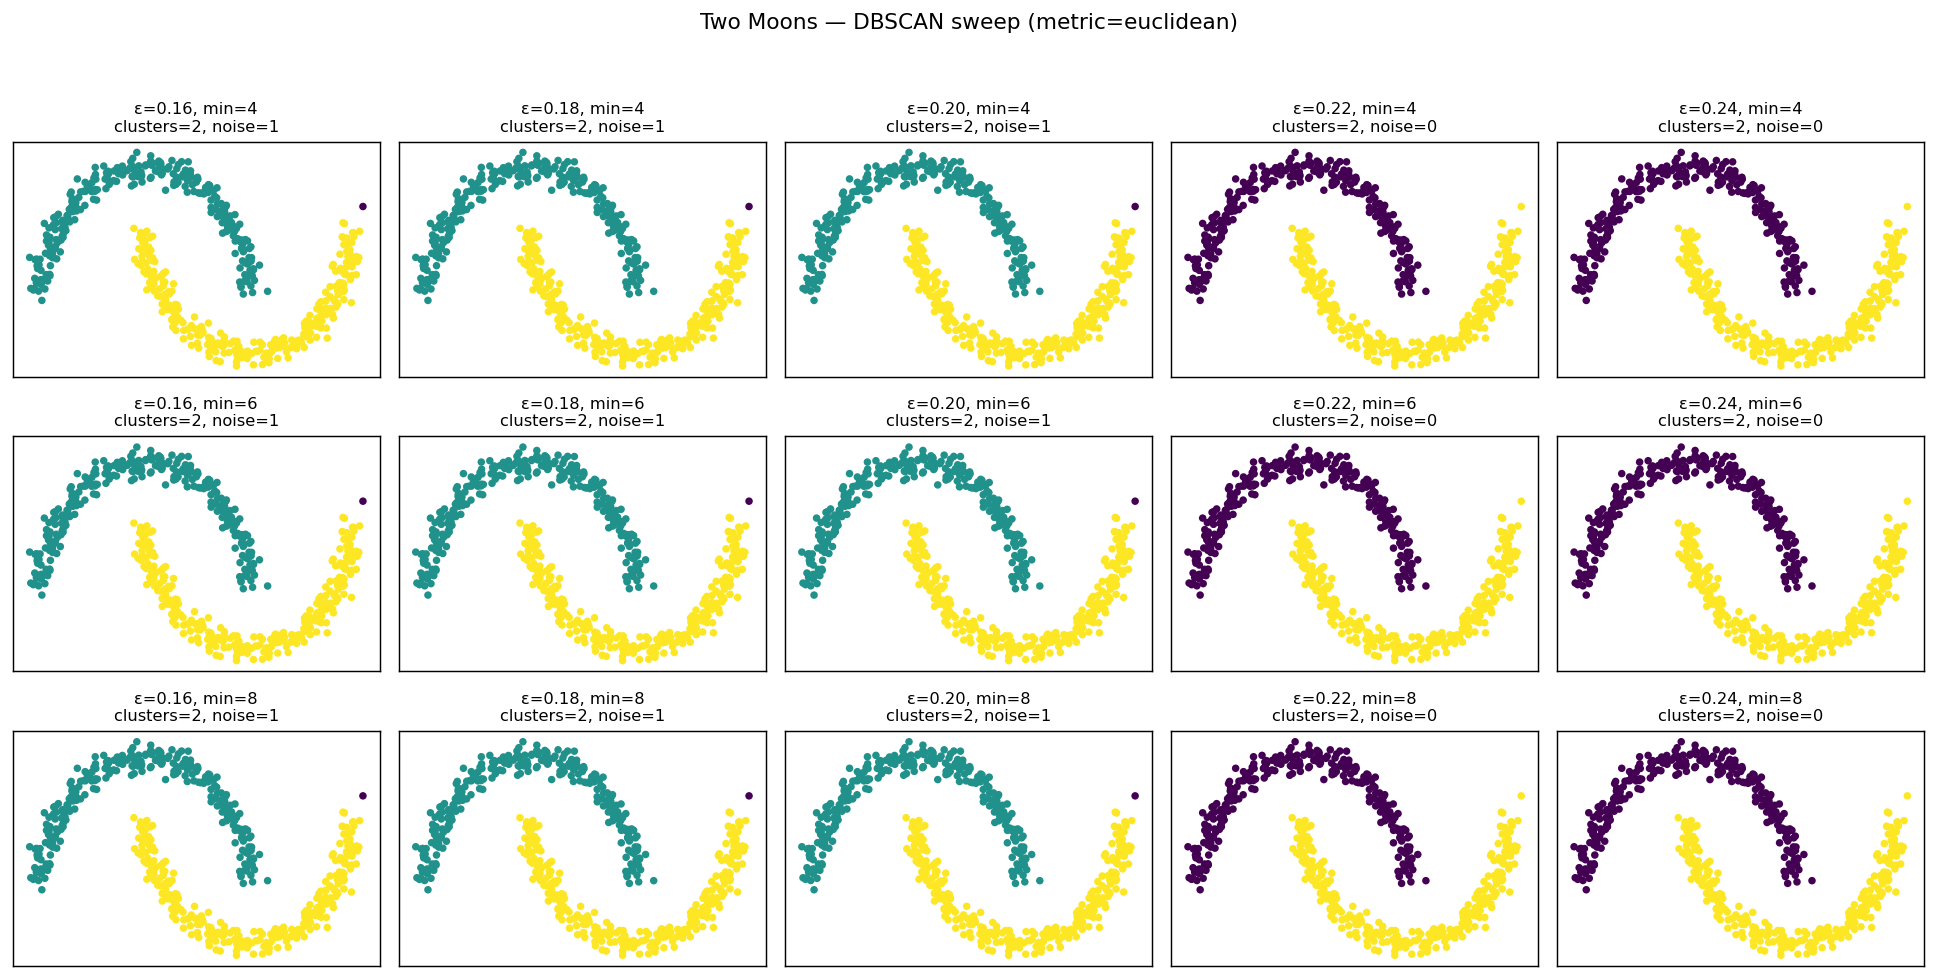

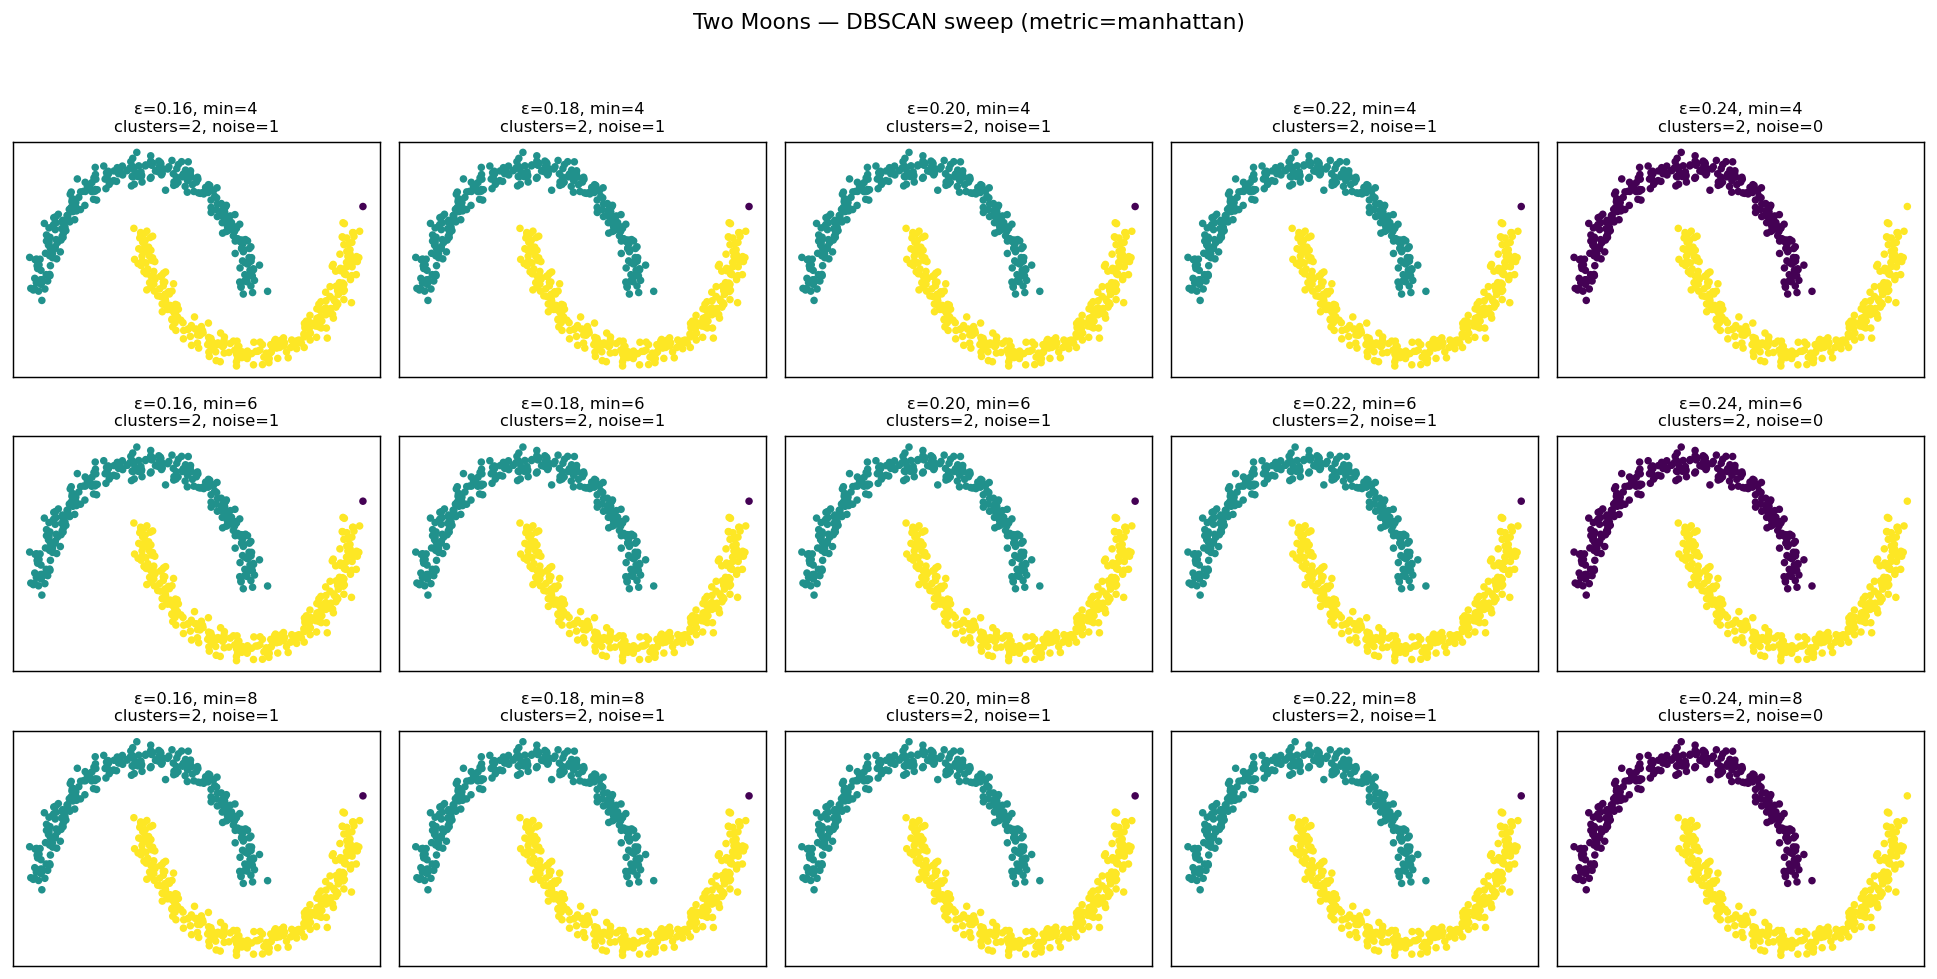

In [5]:
eps_vals = [0.16, 0.18, 0.20, 0.22, 0.24]
min_vals = [4, 6, 8]

sweep_grid(X_moons, "Two Moons", eps_vals, min_vals, metric="euclidean")
sweep_grid(X_moons, "Two Moons", eps_vals, min_vals, metric="manhattan")


## 4) Example B — Concentric Circles

Another DBSCAN classic: two rings with a bit of noise. This dataset has more noise than the make_moons data and has one cluster nested within the other. First we will visualize the raw data and then we will test DBScan on it with a single set of parameters. 


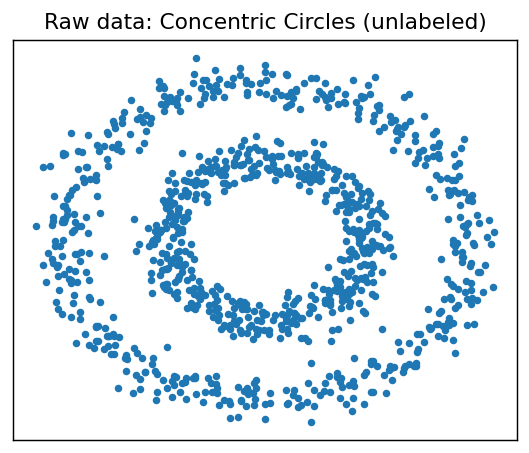

In [6]:
X_circ, _ = make_circles(n_samples=1000, factor=0.5, noise=0.07, random_state=7)

plt.figure(figsize=(5, 4))
plt.scatter(X_circ[:, 0], X_circ[:, 1], s=10)
plt.title("Raw data: Concentric Circles (unlabeled)")
plt.xticks([]); plt.yticks([])
plt.show()


We can see when we test the make_circles dataset with DBScan with `eps=0.18`, `min_samples=6`, and `metric="euclidean"` that our algorithim does not correctly find two concentric cluster. Thus we can use a parameter sweep to see if we can find a better set of `eps` and `min_samples`.

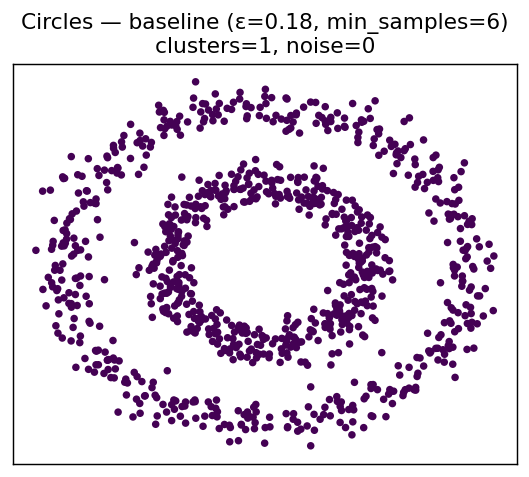

In [7]:
model = DBScan(eps=0.18, min_samples=6, metric="euclidean")
labels, k = model.fit_predict(X_circ)
s = summarize_dbscan(labels)

plt.figure(figsize=(5, 4))
plt.scatter(X_circ[:, 0], X_circ[:, 1], c=labels, s=10)
plt.title(f"Circles — baseline (ε=0.18, min_samples=6)\nclusters={k}, noise={s['noise_points']}")
plt.xticks([]); plt.yticks([])
plt.show()


### Parameter sweep 
Now we will perform a parameter sweep to better visualize how our choice of epsilon and min_samples effects our clustering.
For the grid of plots: Rows = `min_samples`, columns = `eps`. Since the make_circle data is less clean than the make_moons data, the we see major changes as we change our parameters. As we change our `min_samples`, the clustering appears to get better in models using the `euclidean` metric. For the `manhattan` metric, we see if `min_samples` becomes too high, then the model begins to break each ring into multiple clusters which is not what we want. With both metrics, the model struggles to correctly label points that are between the two rings. This is expected. 

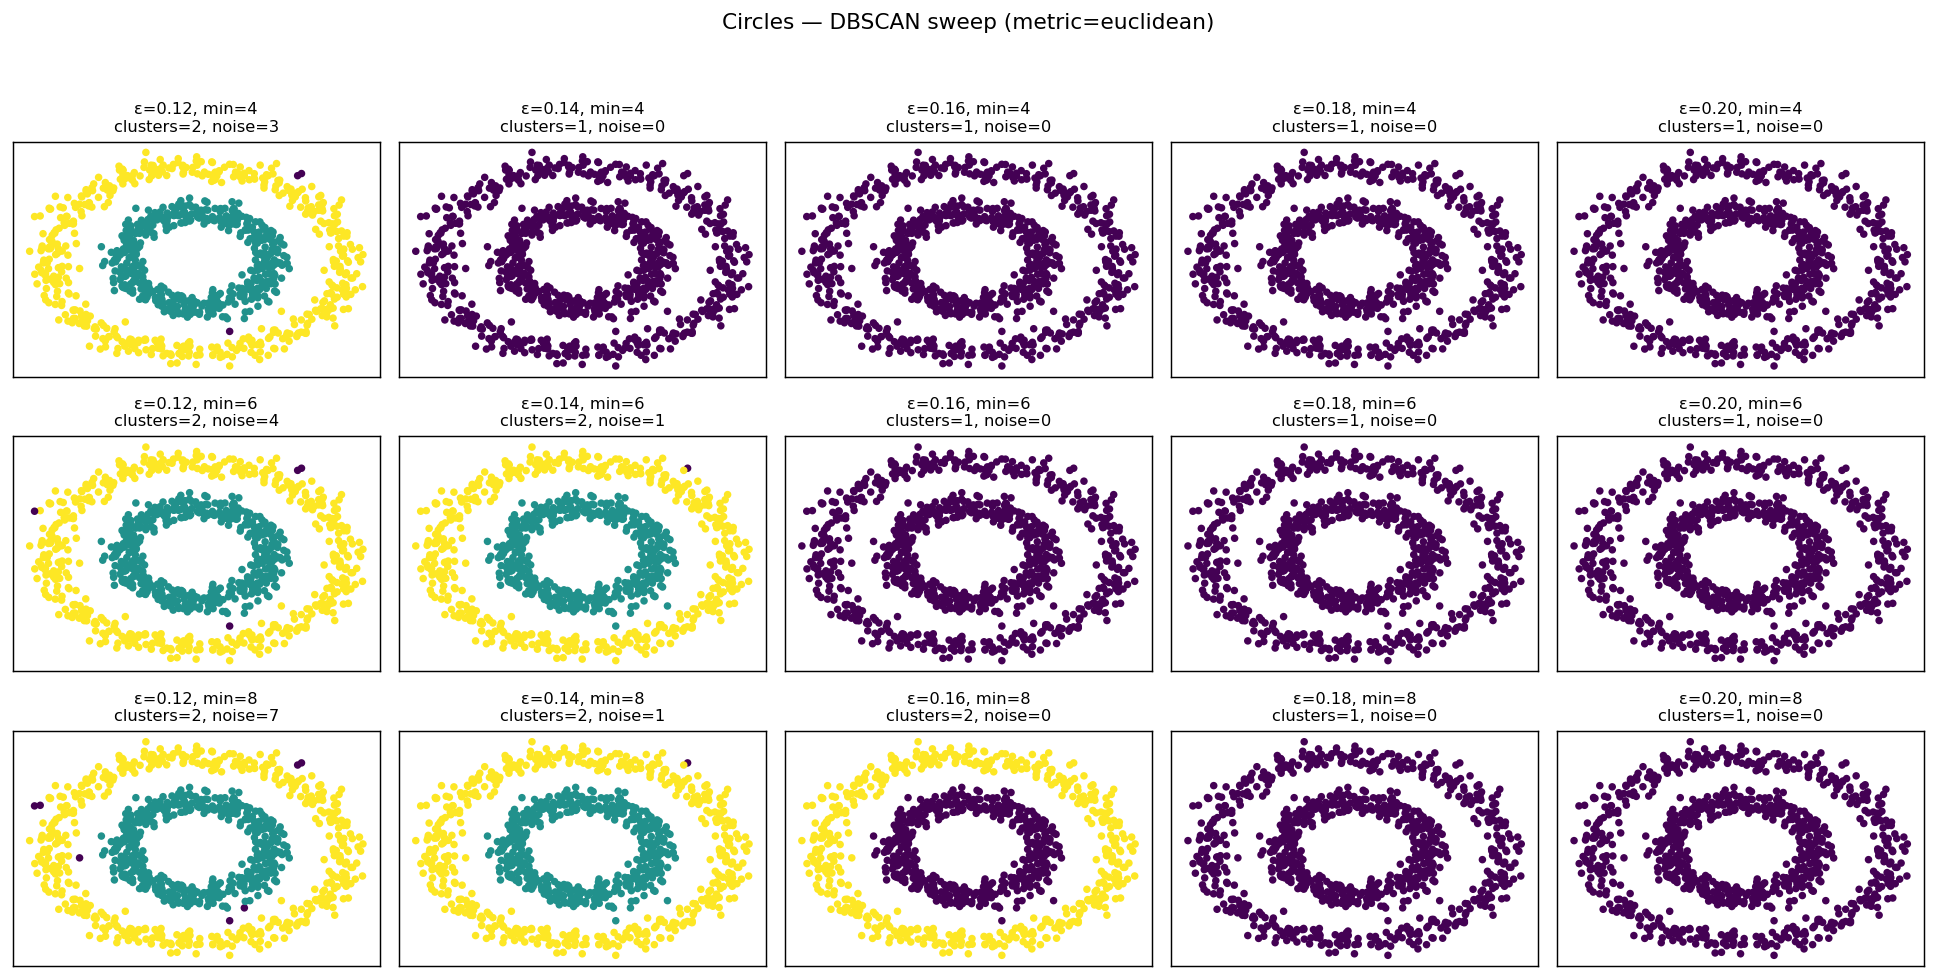

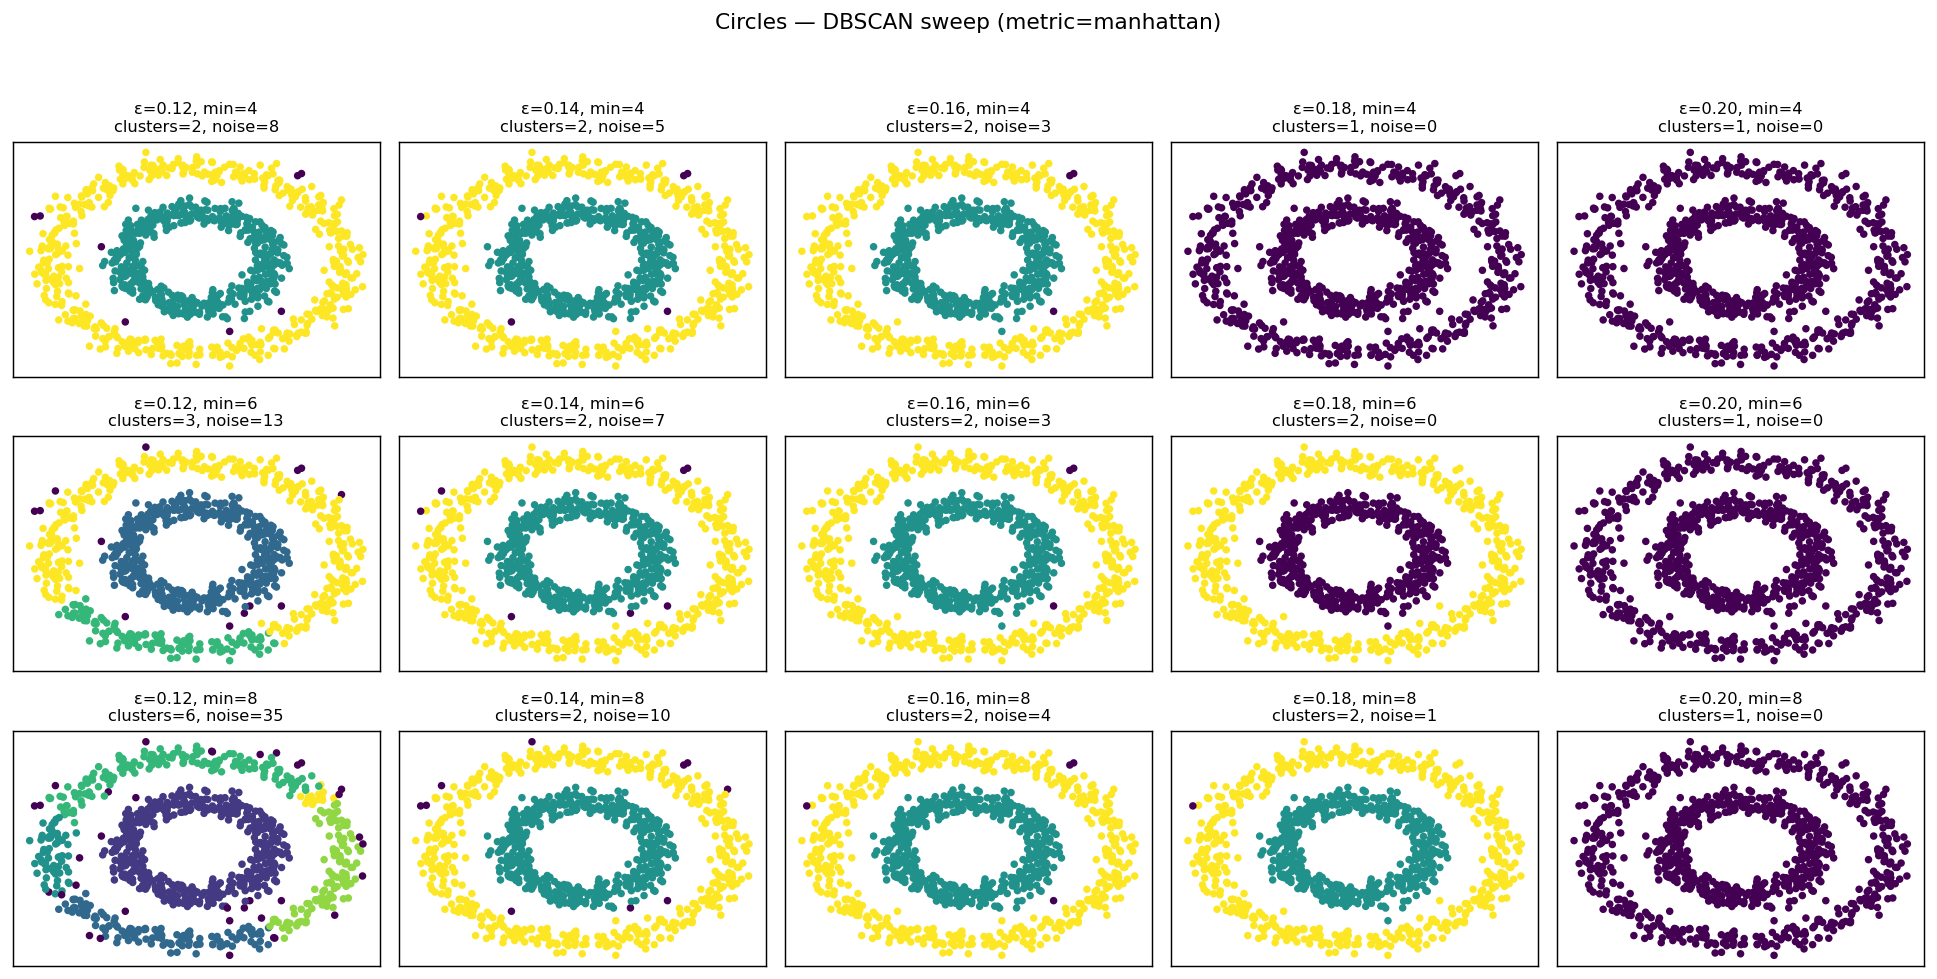

In [8]:
eps_vals = [0.12, 0.14, 0.16, 0.18, 0.20]
min_vals = [4, 6, 8]

sweep_grid(X_circ, "Circles", eps_vals, min_vals, metric="euclidean")
sweep_grid(X_circ, "Circles", eps_vals, min_vals, metric="manhattan")


## 5) Example C — Blobs (sanity check)

Blobs are more “spherical,” so DBSCAN often works but is sensitive to `eps` and feature scaling.
We standardize features first.

Another DBSCAN classic: two rings with a bit of noise. This dataset has more less noise than the make_circles data and has separate, circular clusters. First we will visualize the raw data and then we will test DBScan on it with a single set of parameters. 


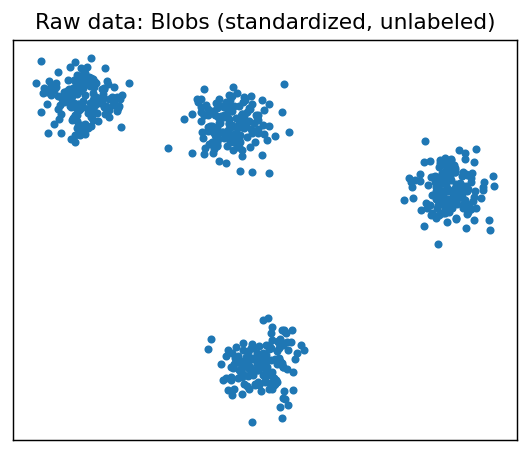

In [9]:
X_blob, _ = make_blobs(n_samples=600, centers=4, cluster_std=1, random_state=7)
X_blob = StandardScaler().fit_transform(X_blob)

plt.figure(figsize=(5, 4))
plt.scatter(X_blob[:, 0], X_blob[:, 1], s=12)
plt.title("Raw data: Blobs (standardized, unlabeled)")
plt.xticks([]); plt.yticks([])
plt.show()


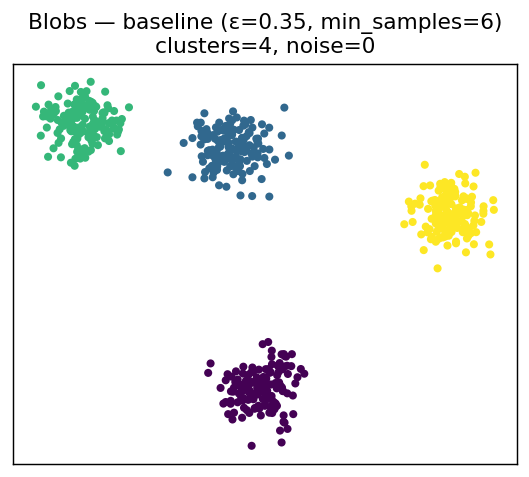

In [10]:
model = DBScan(eps=0.35, min_samples=6, metric="euclidean")
labels, k = model.fit_predict(X_blob)
s = summarize_dbscan(labels)

plt.figure(figsize=(5, 4))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=labels, s=12)
plt.title(f"Blobs — baseline (ε=0.35, min_samples=6)\nclusters={k}, noise={s['noise_points']}")
plt.xticks([]); plt.yticks([])
plt.show()


### Parameter sweep 
Now we will perform a parameter sweep to better visualize how our choice of epsilon and min_samples effects our clustering.
For the grid of plots: Rows = `min_samples`, columns = `eps`. The `manhattan` metric performs worse than the `euclidean` metric when it comes to correctly identifying noise. 

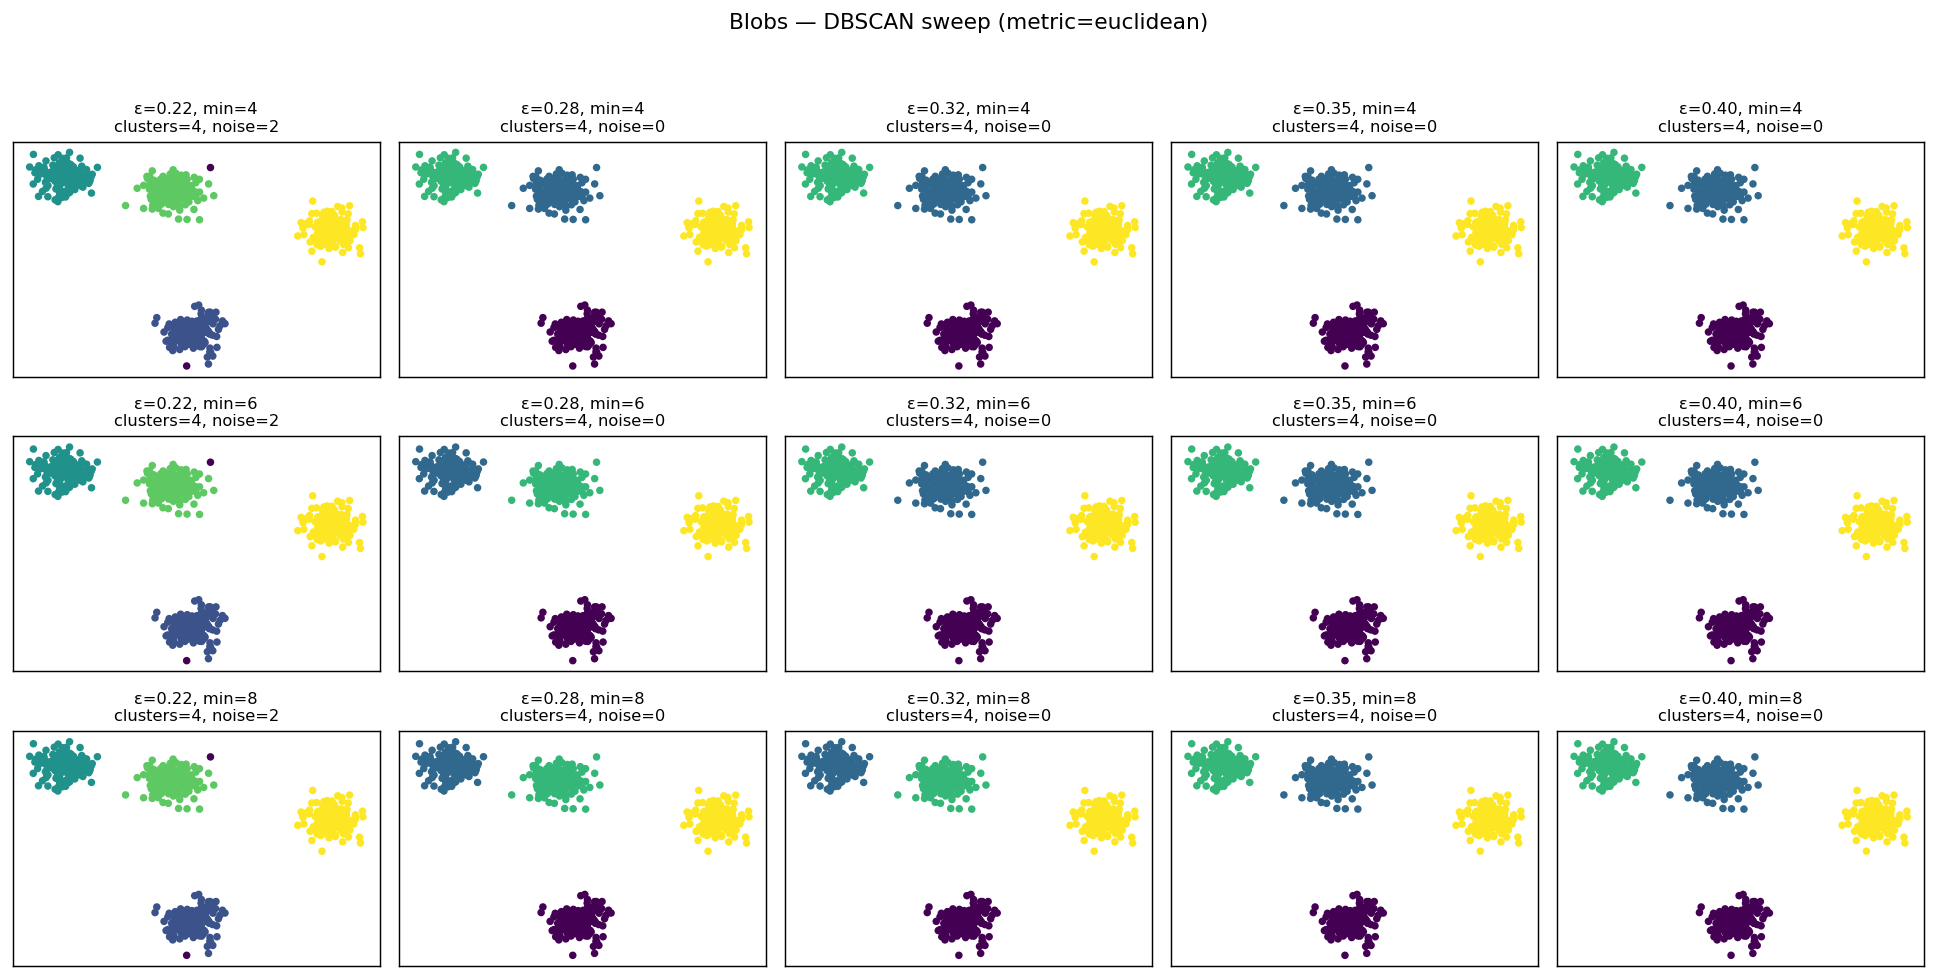

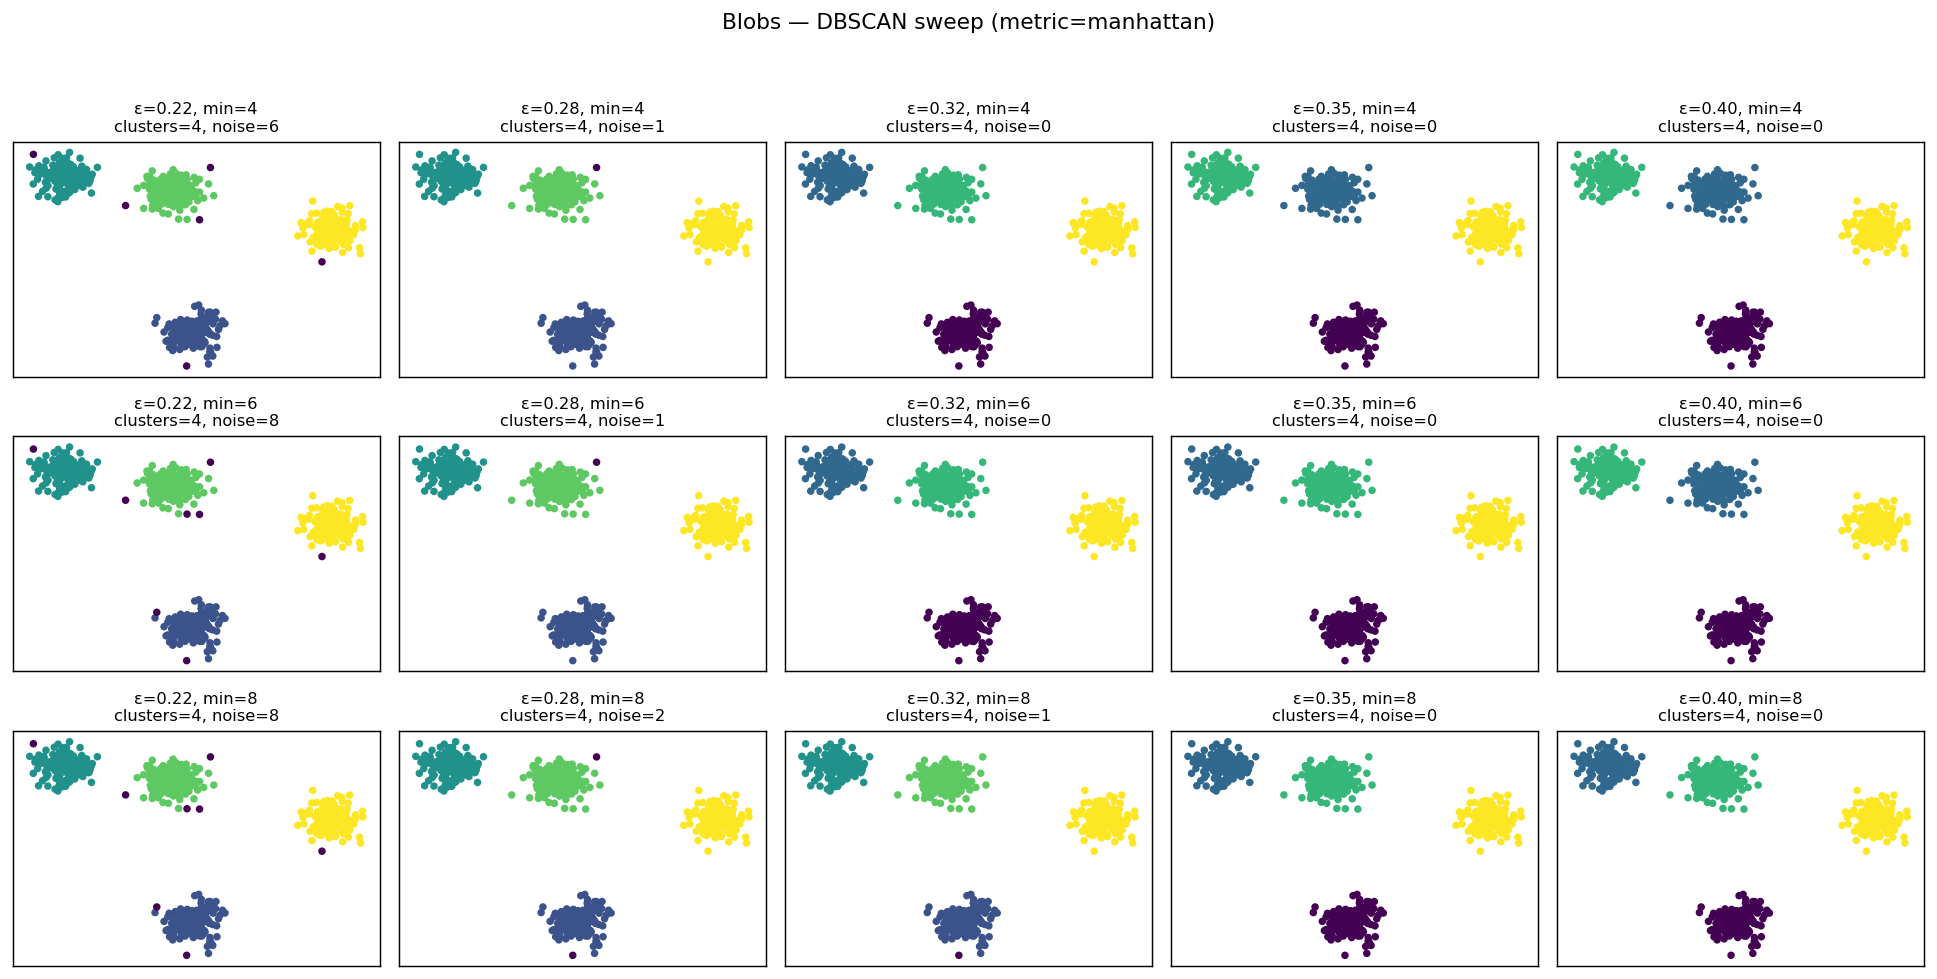

In [11]:
eps_vals = [0.22, 0.28, 0.32, 0.35, 0.40]
min_vals = [4, 6, 8]

sweep_grid(X_blob, "Blobs", eps_vals, min_vals, metric="euclidean")
sweep_grid(X_blob, "Blobs", eps_vals, min_vals, metric="manhattan")


---

### Notes
- If you see **everything turn to noise**, increase `eps` or reduce `min_samples`.
- If you see **one giant cluster**, reduce `eps`.
- Manhattan vs Euclidean can differ when cluster shapes are “taxicab-like” or dimensions have different roles.
